In [1]:
from pathlib import Path
import pandas as pd

# Resolve project root safely
BASE_DIR = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

# Define paths
IFOREST_PATH = BASE_DIR / "data" / "processed" / "iforest_scores.csv"
AE_PATH = BASE_DIR / "data" / "processed" / "ae_scores.csv"

# Optional safety checks
assert IFOREST_PATH.exists(), f"Missing file: {IFOREST_PATH}"
assert AE_PATH.exists(), f"Missing file: {AE_PATH}"

# Load scores
if_df = pd.read_csv(IFOREST_PATH)
ae_df = pd.read_csv(AE_PATH)

# Combine scores
scores = pd.DataFrame({
    "if_score": if_df["anomaly_score"],
    "ae_score": ae_df["ae_score"]
})


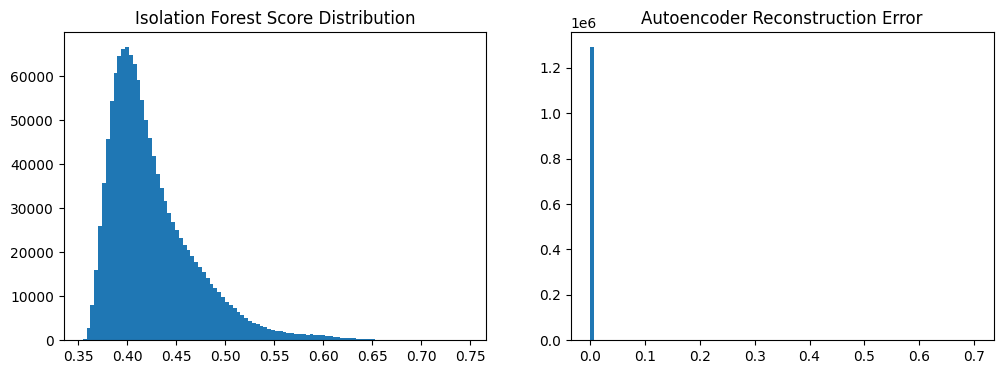

In [2]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12,4))

axes[0].hist(scores["if_score"], bins=100)
axes[0].set_title("Isolation Forest Score Distribution")

axes[1].hist(scores["ae_score"], bins=100)
axes[1].set_title("Autoencoder Reconstruction Error")

plt.show()


In [3]:
from scipy.stats import spearmanr

rho, _ = spearmanr(scores["if_score"], scores["ae_score"])
rho


np.float64(0.6452397503272778)

In [5]:
from pathlib import Path

BASE_DIR = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
PROCESSED_DIR = BASE_DIR / "data" / "processed"

list(PROCESSED_DIR.iterdir())


[PosixPath('/home/caleb/transaction-anomaly-ml/data/processed/X_val.npy'),
 PosixPath('/home/caleb/transaction-anomaly-ml/data/processed/y_val.npy'),
 PosixPath('/home/caleb/transaction-anomaly-ml/data/processed/X_train.npy'),
 PosixPath('/home/caleb/transaction-anomaly-ml/data/processed/features.parquet'),
 PosixPath('/home/caleb/transaction-anomaly-ml/data/processed/scaler.joblib'),
 PosixPath('/home/caleb/transaction-anomaly-ml/data/processed/ae_scores.csv'),
 PosixPath('/home/caleb/transaction-anomaly-ml/data/processed/iforest_scores.csv'),
 PosixPath('/home/caleb/transaction-anomaly-ml/data/processed/feature_scaler.joblib')]

In [6]:
from pathlib import Path
import pandas as pd

BASE_DIR = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

RAW_DATA_PATH = BASE_DIR / "data" / "creditcard.csv"
METADATA_PATH = BASE_DIR / "data" / "processed" / "metadata.parquet"

# Ensure processed directory exists
METADATA_PATH.parent.mkdir(parents=True, exist_ok=True)

# Load only metadata columns
meta = pd.read_csv(
    RAW_DATA_PATH,
    usecols=["trans_date_trans_time"],
    parse_dates=["trans_date_trans_time"]
)

# Save metadata
meta.to_parquet(METADATA_PATH, index=False)

print("✅ metadata.parquet created")


✅ metadata.parquet created


In [7]:
# Resolve project root safely
BASE_DIR = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

# Define metadata path
METADATA_PATH = BASE_DIR / "data" / "processed" / "metadata.parquet"

# Optional safety check
assert METADATA_PATH.exists(), f"Missing file: {METADATA_PATH}"

# Load metadata
meta = pd.read_parquet(METADATA_PATH)

# Add timestamps
scores["timestamp"] = pd.to_datetime(meta["trans_date_trans_time"])
scores["date"] = scores["timestamp"].dt.date


In [8]:
daily = scores.groupby("date").mean()


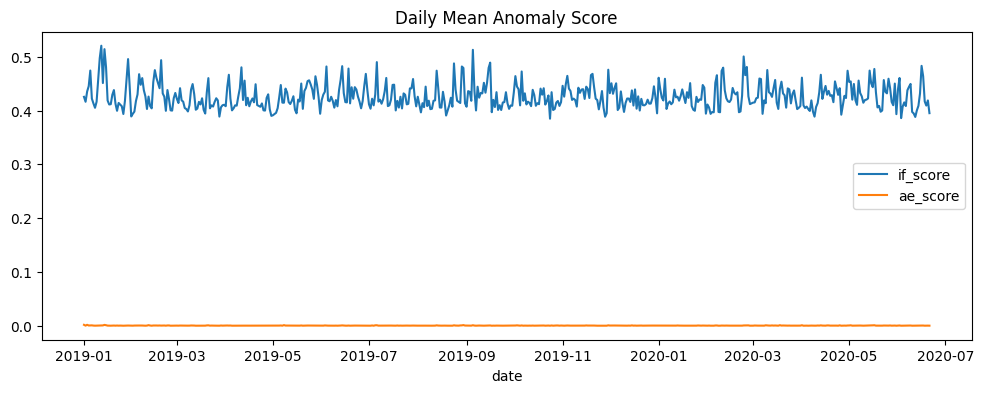

In [9]:
daily[["if_score", "ae_score"]].plot(figsize=(12,4))
plt.title("Daily Mean Anomaly Score")
plt.show()


In [10]:
import numpy as np

if_thresh = np.percentile(scores["if_score"], 99)
ae_thresh = np.percentile(scores["ae_score"], 99)

scores["if_alert"] = scores["if_score"] >= if_thresh
scores["ae_alert"] = scores["ae_score"] >= ae_thresh


In [11]:
overlap = (
    (scores["if_alert"] & scores["ae_alert"]).sum()
    / scores["if_alert"].sum()
)

overlap


np.float64(0.6400092542608159)